In [4]:
import pandas as pd 
import numpy  as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, cohen_kappa_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

np.random.seed(42)
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)        # Unlimited width display
pd.set_option('display.max_colwidth', None) # Show full content of each column

In [3]:
df_train = pd.read_csv("./data/train.csv")
df_train.head(300).to_csv("./data/sample_train.csv")
df_train.set_index('Id', inplace=True)
df_train.rename(columns={'Response': 'target'}, inplace=True)
dc = df_train.describe(include='all')  # All columns including categorical

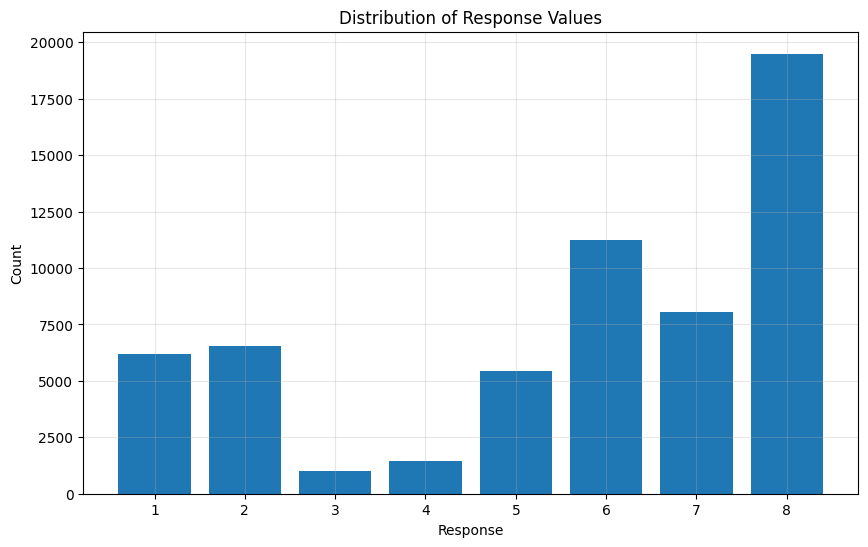

In [79]:
response_counts = df_train['target'].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(response_counts.index, response_counts.values)
plt.title('Distribution of Response Values')
plt.xlabel('Response')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.show()

In [80]:
# Calculate percentage of NaN values for each column
nan_stats = (df_train.isna().sum() / len(df_train) * 100).sort_values(ascending=False)

# Create a DataFrame with the statistics
nan_stats_df = pd.DataFrame({
    'Column': nan_stats.index,
    'NaN %': nan_stats.values
})

# Display results
print("Percentage of NaN values in each column (sorted):")
print(nan_stats_df)

Percentage of NaN values in each column (sorted):
                 Column      NaN %
0    Medical_History_10  99.061990
1    Medical_History_32  98.135767
2    Medical_History_24  93.598963
3    Medical_History_15  75.101463
4         Family_Hist_5  70.411411
..                  ...        ...
122   Medical_History_7   0.000000
123   Medical_History_6   0.000000
124   Medical_History_5   0.000000
125   Medical_History_4   0.000000
126              target   0.000000

[127 rows x 2 columns]


In [134]:
X = df_train.drop('target', axis=1)
y = df_train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

In [135]:
def drop_high_missing_columns(X, threshold=80):
    """
    Drop columns with missing values percentage higher than the threshold
    """
    missing_percent = X.isnull().mean() * 100
    columns_to_keep = missing_percent[missing_percent <= threshold].index.tolist()
    return X[columns_to_keep]


class MissingIndicator:
    def __init__(self, threshold=80):
        self.threshold = threshold
        self.high_missing_cols = None
        self.low_missing_cols = None
    
    def fit(self, X, y=None):
        # Convert to DataFrame if not already
        X_df = pd.DataFrame(X)
        # Identify columns with high missing values
        missing_percent = X_df.isnull().mean() * 100
        self.high_missing_cols = [col for col, perc in missing_percent.items() if perc > self.threshold]
        self.low_missing_cols = [col for col, perc in missing_percent.items() if perc <= self.threshold]
        return self
    
    def transform(self, X):
        # Convert to DataFrame if not already
        X_df = pd.DataFrame(X)
        # Return only columns with low missing values
        return X_df[self.low_missing_cols]
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

In [136]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)  # This will convert [1,2,3,4,5,6,7,8] to [0,1,2,3,4,5,6,7]


In [140]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBClassifier

# Identify column types
numeric_cols = X.select_dtypes(include=['number']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Pipeline for numeric features
numeric_transformer = Pipeline(steps=[
#    ('missing_filter', MissingIndicator(threshold=90)),
#    ('missing_flag', MissingIndicator()),
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Pipeline for categorical features
categorical_transformer = Pipeline(steps=[
#    ('missing_filter', MissingIndicator(threshold=80)),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='drop'  # Drop any other columns
)

# Full pipeline with model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
#    ('variance_threshold', VarianceThreshold(threshold=0.01)),  # Remove low-variance features
    ('classifier', XGBClassifier(n_estimators=100, objective='reg:linear', eta=0.05, min_child_weight=360, subsample=0.85, colsample_bytree=0.3, silent=1, max_depth=7, n_jobs=-1, random_state=42))
])

In [146]:
model_pipeline.fit(X_train, y_train-1)
y_pred = model_pipeline.predict(X_test)
kappa = cohen_kappa_score(y_test-1, y_pred-1, weights='quadratic')

/Users/atisanchez/pj/current/ml-prudential-insurance/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:21:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "silent" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [147]:
kappa

np.float64(0.5090157263233238)